In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

os.makedirs('./data/timings', exist_ok=True)

In [2]:
import torch
import numpy as np
import random

def seed_everything():
    torch.manual_seed(0)
    random.seed(0)
    np.random.seed(0)

In [3]:
model_names_dicts = {
    'baseline': 'TXT-Baseline', 
    'word_bias': 'Word-Bias', 
    'onehot': 'OneHot', 
    'peb': 'HuBi-Formula', 
    'bias': 'HuBi-Simple', 
    'embedding': 'HuBi-Medium', 
    'word_embedding': 'HuBi-Complex'
}
model_names_order = list(model_names_dicts.values())

language_model_names_dicts = {
    'xlmr': 'XLM-R', 
    'bert': 'BERT', 
    'deberta': 'DeBERTa',
    'labse': 'LaBSE',
}

## Import models

In [4]:
results = []

In [5]:
import os
from itertools import product

from personalized_nlp.learning.train import train_test
from personalized_nlp.models import models as models_dict
from personalized_nlp.settings import LOGS_DIR
from personalized_nlp.datasets.emotions.emotions import EmotionsDataModule
from personalized_nlp.utils import seed_everything
from personalized_nlp.utils.callbacks.time import TimingCallback
from pytorch_lightning import loggers as pl_loggers

wandb_project_name = 'null'
regression = True
datamodule_cls = EmotionsDataModule
#embedding_types = ['deberta']
#embedding_types = ['labse']
embedding_types = ['labse', 'xlmr', 'deberta']
model_types = ['baseline', 'onehot', 'peb', 'bias', 'word_bias', 'embedding', 'word_embedding']
limit_past_annotations_list = [None] # range(20)
fold_nums = 10

min_word_counts = [200]
words_per_texts = [100]

batch_size = 1000
dp_embs = [0.25]
embedding_dims = [50]
epochs = 3
lr_rate = 0.008
user_folding = True
test_repetitions = 100

use_cuda = True

for (min_word_count, words_per_text, embeddings_type, limit_past_annotations) in product(
    min_word_counts, words_per_texts, embedding_types, limit_past_annotations_list
):

    seed_everything()
    data_module = datamodule_cls(
        embeddings_type=embeddings_type, normalize=regression, batch_size=batch_size,
        past_annotations_limit=limit_past_annotations
    )
    data_module.prepare_data()
    data_module.setup()
    data_module.compute_word_stats(
        min_word_count=min_word_count,
        min_std=0.0,
        words_per_text=words_per_text,
    )

    for model_type, embedding_dim, dp_emb, fold_num in product(
        model_types, embedding_dims, dp_embs, range(fold_nums)
    ):
        hparams = {
            "dataset": type(data_module).__name__,
            "model_type": model_type,
            "embeddings_type": embeddings_type,
            "embedding_size": embedding_dim,
            "fold_num": fold_num,
            "regression": regression,
            "words_per_texts": words_per_text,
            "min_word_count": min_word_count,
            "dp_emb": dp_emb,
        }

        logger = pl_loggers.WandbLogger(
            save_dir=LOGS_DIR,
            config=hparams,
            project=wandb_project_name,
            log_model=False,
        )

        output_dim = len(data_module.class_dims) if regression else sum(data_module.class_dims)
        text_embedding_dim = data_module.text_embedding_dim
        model_cls = models_dict[model_type]
        
        model = model_cls(
            output_dim=output_dim,
            text_embedding_dim=text_embedding_dim,
            word_num=data_module.words_number,
            annotator_num=data_module.annotators_number,
            dp=0.0,
            dp_emb=dp_emb,
            embedding_dim=embedding_dim,
            hidden_dim=100,
            bias_vector_length=len(data_module.class_dims)
        )

        test_fold = fold_num if user_folding else None
        timing_callback = TimingCallback()
        trainer = train_test(
            data_module,
            model,
            epochs=epochs,
            lr=lr_rate,
            regression=regression,
            use_cuda=use_cuda,
            logger=logger,
            test_fold=test_fold,
            custom_callbacks=[timing_callback], 
            test_repetitions=test_repetitions
        )

        logger.experiment.finish()
        
        results.append((hparams, timing_callback, trainer.model))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: satyrr (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name    | Type       | Params
---------------------------------------
0 | model   | Net        | 7.7 K 
1 | metrics | ModuleDict | 0     
---------------------------------------
7.7 K     Trainable params
0         Non-trainable params
7.7 K     Total params
0.031     Total estimated model params size (MB)


/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:679: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


/home/mgruza/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.08458543568849564,
 'test_r2_OCZEKIWANIE': 0.01248194184154272,
 'test_r2_POBUDZENIE EMOCJONALNE': -0.006965355481952429,
 'test_r2_RADOŚĆ': 0.15714210271835327,
 'test_r2_SMUTEK': 0.09816141426563263,
 'test_r2_STRACH': -0.007264277432113886,
 'test_r2_WSTRĘT': 0.06907856464385986,
 'test_r2_ZASKOCZENIE': -0.03362727537751198,
 'test_r2_ZAUFANIE': 0.09430740028619766,
 'test_r2_ZNAK EMOCJI': 0.19301649928092957,
 'test_r2_ZŁOŚĆ': 0.1559329479932785,
 'test_r2_mean': 0.07322639226913452}
--------------------------------------------------------------------------------



train_loss_step,0.08772
epoch,2
trainer/global_step,660
_runtime,11
_timestamp,1639432967
_step,19
valid_loss,0.08306
valid_r2_OCZEKIWANIE,-0.01732
valid_r2_POBUDZENIE EMOCJONALNE,-0.02682
valid_r2_RADOŚĆ,0.12891
valid_r2_SMUTEK,0.09508


train_loss_step,█▁▃▂▂▁▁▃▂▂▂▂▂
epoch,▁▁▁▁▁▁▅▅▅▅▅▅████████
trainer/global_step,▁▂▂▃▃▃▃▄▄▅▅▅▆▆▇▇████
_runtime,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃█
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃█
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
valid_loss,▄▁█
valid_r2_OCZEKIWANIE,▅█▁
valid_r2_POBUDZENIE EMOCJONALNE,▃█▁
valid_r2_RADOŚĆ,▂█▁
valid_r2_SMUTEK,▁██


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name    | Type       | Params
---------------------------------------
0 | model   | Net        | 7.7 K 
1 | metrics | ModuleDict | 0     
---------------------------------------
7.7 K     Trainable params
0         Non-trainable params
7.7 K     Total params
0.031     Total estimated model params size (MB)


## Training time results

In [ ]:
from collections import defaultdict
import pandas as pd 

result_dict = defaultdict(list)

for hparams, callback, model in results:
    for hparam_key, hparam_value in hparams.items():
        result_dict[hparam_key].append(hparam_value)
    
    epoch_stats = callback.epoch_stats[1:]
    
    best_epoch_idx = np.argmin([es[2] for es in epoch_stats])
    
    result_dict['training_time'].append(epoch_stats[best_epoch_idx][1]) 
    result_dict['best_epoch'].append(best_epoch_idx) 
    
results_df = pd.DataFrame(result_dict)
results_df

,dataset,model_type,embeddings_type,embedding_size,fold_num,regression,words_per_texts,min_word_count,dp_emb,training_time,best_epoch
0,EmotionsDataModule,baseline,labse,50,0,True,100,200,0.25,2.141013,1
1,EmotionsDataModule,onehot,labse,50,0,True,100,200,0.25,2.284283,1
2,EmotionsDataModule,peb,labse,50,0,True,100,200,0.25,3.147400,2
3,EmotionsDataModule,bias,labse,50,0,True,100,200,0.25,3.995594,2
4,EmotionsDataModule,word_bias,labse,50,0,True,100,200,0.25,1.257690,0
5,EmotionsDataModule,embedding,labse,50,0,True,100,200,0.25,4.309278,2
6,EmotionsDataModule,word_embedding,labse,50,0,True,100,200,0.25,4.616602,2


In [ ]:

import pandas as pd 
results_df.to_csv('./data/timings/training.times.csv')
results_df = pd.read_csv('./data/timings/training.times.csv')

results_df['model type'] = results_df['model_type'].apply(model_names_dicts.get)
results_df['embeddings type'] = results_df['embeddings_type'].apply(language_model_names_dicts.get)
results_df = results_df.sort_values(by='model type', key=lambda x: x.map(model_names_order.index))

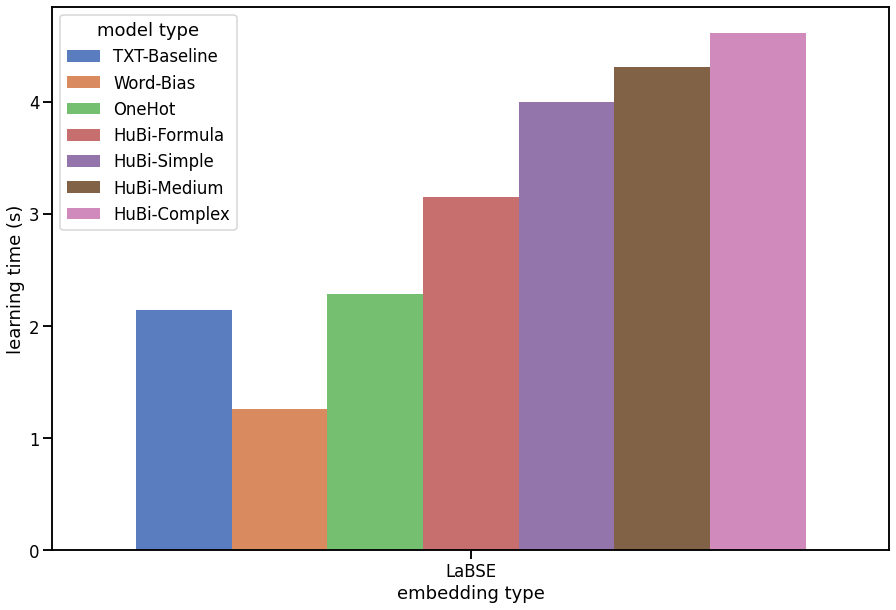

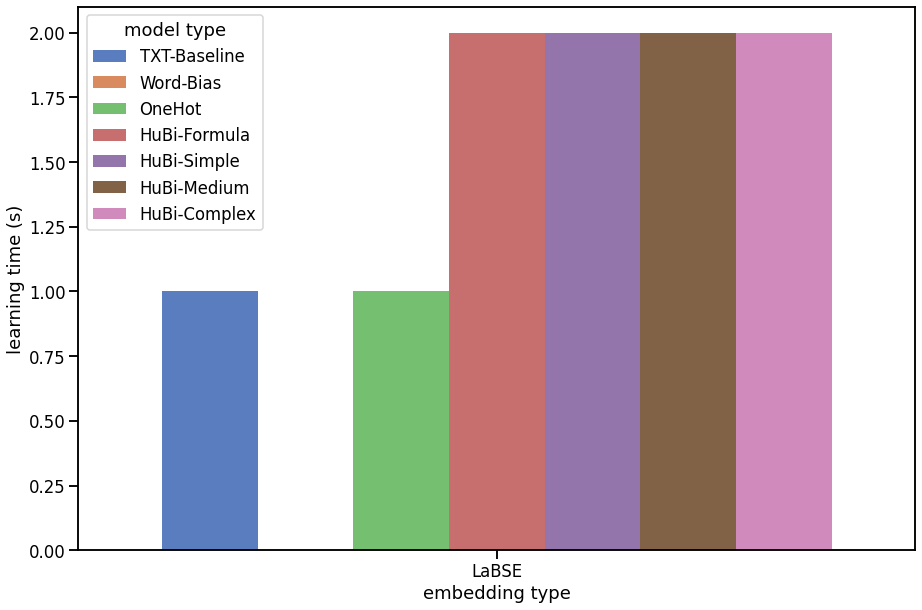

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

sns.set_context('talk')
sns.set_palette('muted')
plt.figure(figsize=(15,10))
sns.barplot(data=results_df, hue='model type', y='training_time', x='embeddings type')
plt.ylabel('learning time (s)')
plt.xlabel('embedding type')
plt.savefig('trainig_time_emotions.pdf')

plt.figure(figsize=(15,10))

sns.barplot(data=results_df, hue='model type', y='best_epoch', x='embeddings type')

plt.ylabel('learning time (s)')
plt.xlabel('embedding type')

plt.savefig('')

## Testing time results

In [ ]:
from collections import defaultdict
import pandas as pd 

result_dict = defaultdict(list)

for hparams, callback, model in results:

    for hparam_key, hparam_value in hparams.items():
        result_dict[hparam_key].append(hparam_value)
    
    result_dict['test_time_mean'].append(np.sum(model.testing_times) / test_repetitions) 
    result_dict['test_time_std'].append(np.std(model.testing_times)) 
    
results_df = pd.DataFrame(result_dict)
results_df

,dataset,model_type,embeddings_type,embedding_size,fold_num,regression,words_per_texts,min_word_count,dp_emb,test_time_mean,test_time_std
0,EmotionsDataModule,baseline,labse,50,0,True,100,200,0.25,0.000108,0.000077
1,EmotionsDataModule,onehot,labse,50,0,True,100,200,0.25,0.000154,0.000054
2,EmotionsDataModule,peb,labse,50,0,True,100,200,0.25,0.000156,0.000187
3,EmotionsDataModule,bias,labse,50,0,True,100,200,0.25,0.000365,0.000144
4,EmotionsDataModule,word_bias,labse,50,0,True,100,200,0.25,0.000294,0.000095
5,EmotionsDataModule,embedding,labse,50,0,True,100,200,0.25,0.000422,0.000221
6,EmotionsDataModule,word_embedding,labse,50,0,True,100,200,0.25,0.000436,0.000276


In [ ]:
results_df.to_csv('./data/timings/testing.times.csv')
results_df = pd.read_csv('./data/timings/testing.times.csv')
results_df['model type'] = results_df['model_type'].apply(model_names_dicts.get)
results_df['embeddings type'] = results_df['embeddings_type'].apply(language_model_names_dicts.get)

results_df = results_df.sort_values(by='model type', key=lambda x: x.map(model_names_order.index))


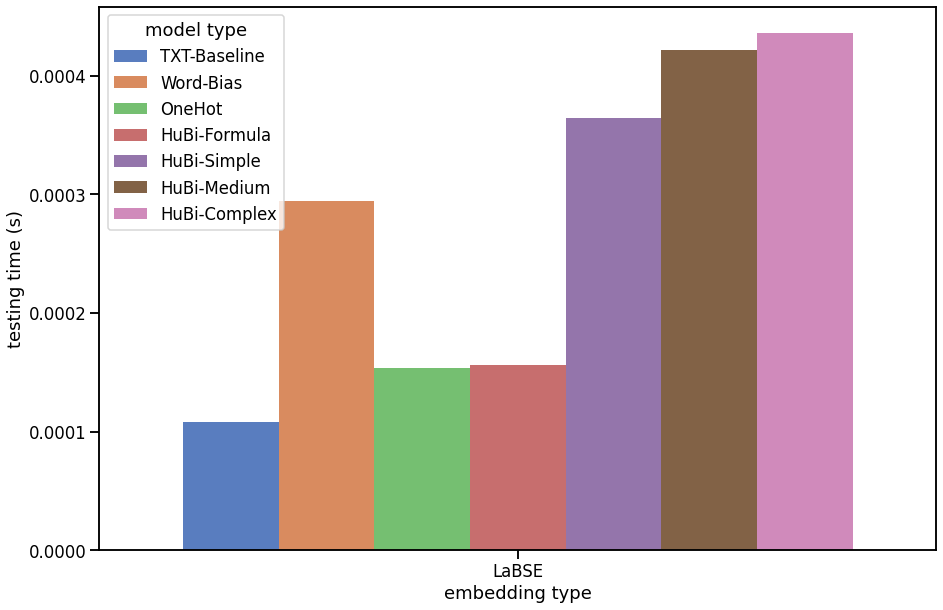

<AxesSubplot:xlabel='embeddings_type', ylabel='test_time_std'>

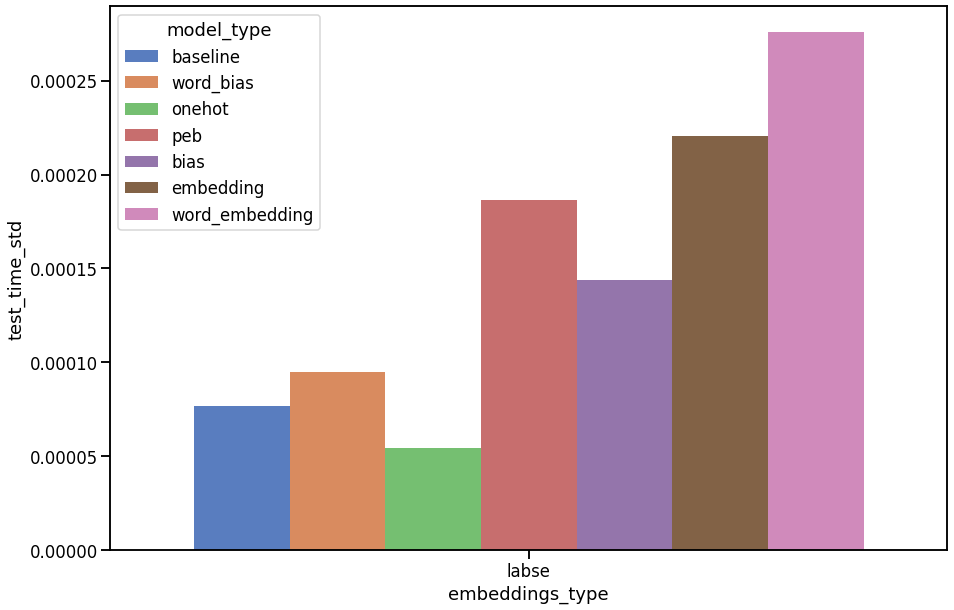

In [ ]:
results_df

import seaborn as sns 
import matplotlib.pyplot as plt

sns.set_context('talk')
plt.figure(figsize=(15,10))
sns.barplot(data=results_df, hue='model type', y='test_time_mean', x='embeddings type')
plt.ylabel('testing time (s)')
plt.xlabel('embedding type')
plt.savefig('testing_time_emotions.pdf')
plt.show()

plt.figure(figsize=(15,10))
sns.barplot(data=results_df, hue='model_type', y='test_time_std', x='embeddings_type')
